In [466]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [426]:
df = pd.DataFrame.from_csv("../data/train_risk.csv", index_col=False)
test = pd.DataFrame.from_csv("../data/test_risk.csv", index_col=False)

In [427]:
X, y = df[df.columns[:-1]], df[df.columns[-1]]

## Analysing the Data

Looking at the difference between the number of positive and negative samples in the dataset shows that there are more negative examples than positive examples. Only 28% of all samples are of the positive class.

In [428]:
def class_balance_summary(y):
    """ Summarise the imbalance in the dataset"""
    total_size = y.size
    negative_class = y[y == 0].size
    positive_class = y[y > 0].size
    ratio = positive_class / float(positive_class + negative_class)

    print "Total number of samples: %d" % total_size
    print "Number of positive samples: %d" % positive_class
    print "Number of negative samples: %d" % negative_class
    print "Ratio of positive to total number of samples: %.2f" % ratio


class_balance_summary(y)

Total number of samples: 300
Number of positive samples: 84
Number of negative samples: 216
Ratio of positive to total number of samples: 0.28


Some initial observations about the data before it is preprocessed:
 - PRE32 is all zeros. This can be removed
 - PRE14 looks catagorical. Consider splitting into multiple binary variables
 - PRE6 looks catagorical. As above.
 - DGN looks catagorical. As above.
 - PRE5 looks to have some outliers. See box plot below. Potentially remove or split into two extra variable?

In [27]:
X.head()

,DGN,PRE4,PRE5,PRE6,PRE7,PRE8,PRE9,PRE10,PRE11,PRE14,PRE17,PRE19,PRE25,PRE30,PRE32,AGE
0,3,2.08,1.52,1,0,0,0,1,0,4,0,0,0,1,0,49
1,3,4.36,3.76,0,0,0,0,0,0,1,0,0,0,1,0,72
2,3,3.52,2.28,0,0,0,0,0,0,3,0,0,0,1,0,51
3,3,3.36,2.67,1,0,0,0,1,0,1,0,0,0,1,0,72
4,3,3.56,2.80,0,0,0,0,0,0,2,0,0,0,0,0,69


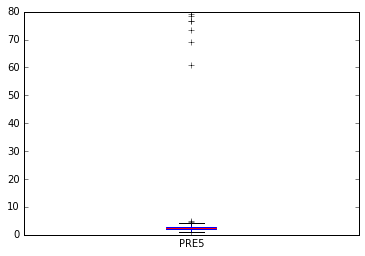

In [21]:
X.PRE5.plot(kind='box')

## Preprocessing

Create a new matrix of preprocessed features. This will encode catagorical data as one hot vectors, remove outliers, and normalise the data.  

In [448]:
from sklearn import preprocessing

def encode_onehot(x_data, column_name):
    """ Encode a catagorical column from a data frame into a data frame of one hot features"""
    enc = preprocessing.OneHotEncoder()
    features = enc.fit_transform(x_data[[column_name]]).toarray()
    names = ['%s_%d' % (column_name, i) for i in enc.active_features_]
    features = pd.DataFrame(features, columns=names, index=x_data.index)
    return features

def preprocess(x_data):
    # drop zero var PRE32
    Xp = x_data.drop("PRE32", axis=1)

    # remove outliers via median fill
    mask = Xp.PRE5 < 30
#     Xp.drop(Xp[~mask].index, inplace=True)
    Yp = y#y.drop(y[~mask].index)

    # encode catagorical data as one hot vectors
    pre14_encoded = encode_onehot(Xp, 'PRE14')
    pre6_encoded = encode_onehot(Xp, 'PRE6')
    dgn_encoded = encode_onehot(Xp, 'DGN')

    #combine into a single data frame
    new_features = pd.concat([pre14_encoded, pre6_encoded, dgn_encoded], axis=1)

    # drop the catagorical variables that have been encoded
    Xp.drop(["PRE14", "PRE6", "DGN"], inplace=True, axis=1)
    # add new features
    Xp = pd.concat([Xp, new_features], axis=1)

    # normalise data
    sclr = preprocessing.StandardScaler()
    Xp = pd.DataFrame(sclr.fit_transform(Xp), columns=Xp.columns)
    return Xp, Yp

Xp, Yp = preprocess(X)
Xp.head()

,PRE4,PRE5,PRE7,PRE8,PRE9,PRE10,PRE11,PRE17,PRE19,PRE25,...,PRE6_0,PRE6_1,PRE6_2,DGN_1,DGN_2,DGN_3,DGN_4,DGN_5,DGN_6,DGN_8
0,-1.576105,-0.243337,-0.252646,-0.457905,-0.26003,0.649462,-0.45257,-0.274352,-0.081923,-0.116248,...,-0.613308,0.728431,-0.281312,-0.057831,-0.351562,0.57735,-0.288154,-0.221249,-0.057831,-0.100504
1,1.448828,-0.035523,-0.252646,-0.457905,-0.26003,-1.539736,-0.45257,-0.274352,-0.081923,-0.116248,...,1.630502,-1.372813,-0.281312,-0.057831,-0.351562,0.57735,-0.288154,-0.221249,-0.057831,-0.100504
2,0.334379,-0.172829,-0.252646,-0.457905,-0.26003,-1.539736,-0.45257,-0.274352,-0.081923,-0.116248,...,1.630502,-1.372813,-0.281312,-0.057831,-0.351562,0.57735,-0.288154,-0.221249,-0.057831,-0.100504
3,0.122103,-0.136647,-0.252646,-0.457905,-0.26003,0.649462,-0.45257,-0.274352,-0.081923,-0.116248,...,-0.613308,0.728431,-0.281312,-0.057831,-0.351562,0.57735,-0.288154,-0.221249,-0.057831,-0.100504
4,0.387448,-0.124586,-0.252646,-0.457905,-0.26003,-1.539736,-0.45257,-0.274352,-0.081923,-0.116248,...,1.630502,-1.372813,-0.281312,-0.057831,-0.351562,0.57735,-0.288154,-0.221249,-0.057831,-0.100504


## Learning

We do not have access to the labels for the final testing dataset. First split the training data into a training and validation set so we have something seperate to test on. Here we're using a  simple 80/20 split. Therefore the validation set contains 60 examples.

In [575]:
from sklearn import cross_validation
Xt, Xv = cross_validation.train_test_split(Xp, test_size = 0.2, stratify=Yp)
Yt, Yv = Yp.loc[Xt.index], Yp.loc[Xv.index]
Xt.shape, Yt.shape, Xv.shape, Yv.shape

((240, 26), (240,), (60, 26), (60,))

In [576]:
from unbalanced_dataset import SMOTE

def apply_smote(x_data, y_data, kind='regular'):
    sm = SMOTE(kind=kind, verbose=2)
    svmx, svmy = sm.fit_transform(x_data.as_matrix(), y_data.as_matrix())
    svmx = pd.DataFrame(svmx, columns=x_data.columns)
    svmy = pd.Series(svmy)
    svmy = svmy.astype(int)
    class_balance_summary(svmy)
    return svmx, svmy

# Xt, Yt = apply_smote(Xt, Yt)

In [577]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

rf = RandomForestClassifier(n_estimators=200)
skf = cross_validation.StratifiedKFold(Yt, n_folds=5)

def test_estimator(x_data, y_data, cv, test_func=None):
    results = []
    for i, (train_idx, test_idx) in enumerate(cv):
        x_train, x_test = x_data.iloc[train_idx], x_data.iloc[test_idx]
        y_train, y_test = y_data.iloc[train_idx], y_data.iloc[test_idx]
        
        rf.fit(x_train, y_train)

        if test_func is not None:
            result = test_func(x_test, y_test, rf)
            results.append(result)

    return results

## ROC Analysis

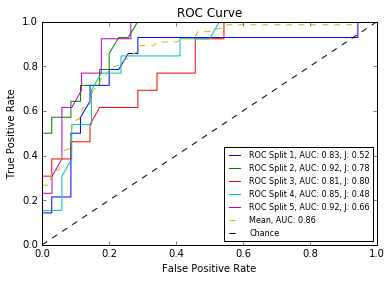

In [578]:
import roc_analysis 
mets = test_estimator(Xt, Yt, skf, test_func=roc_analysis.roc_metrics)
roc_analysis.plot_roc(mets)

J statistic: 0.43
AUC: 0.85


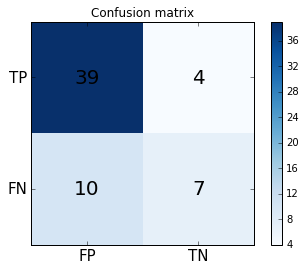

In [579]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    
    width, height = cm.shape
    for x in xrange(width):
        for y in xrange(height):
            plt.annotate(str(cm[x][y]), xy=(y, x), 
                    horizontalalignment='center',
                    verticalalignment='center', size=20)

    plt.xticks([0, 1], ["FP", "TN"], size=15)
    plt.yticks([0, 1], ["TP", "FN"], size=15)
    plt.title(title)
    plt.colorbar()
    plt.show()
    
def print_summary():
    data = roc_analysis.roc_metrics(Xv, Yv, rf)
    print "J statistic: %.2f" % data.j_stat
    print "AUC: %.2f" % data.auc

print_summary()

preds = rf.predict(Xv)
cm = metrics.confusion_matrix(Yv, preds)
plot_confusion_matrix(cm)